<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Extract-information-from-files" data-toc-modified-id="Extract-information-from-files-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Extract information from files</a></span></li><li><span><a href="#Calculate-Errors" data-toc-modified-id="Calculate-Errors-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate Errors</a></span></li><li><span><a href="#Plotting-functions" data-toc-modified-id="Plotting-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting functions</a></span></li></ul></li><li><span><a href="#Use-the-functions" data-toc-modified-id="Use-the-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use the functions</a></span><ul class="toc-item"><li><span><a href="#Initialize-variables" data-toc-modified-id="Initialize-variables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize variables</a></span></li><li><span><a href="#Calculate-the-errors" data-toc-modified-id="Calculate-the-errors-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Calculate the errors</a></span></li><li><span><a href="#Plot-the-errors" data-toc-modified-id="Plot-the-errors-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot the errors</a></span></li><li><span><a href="#Plot-the-correlation-ratios-between-the-corresponding-frames-in-each-sequence" data-toc-modified-id="Plot-the-correlation-ratios-between-the-corresponding-frames-in-each-sequence-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plot the correlation ratios between the corresponding frames in each sequence</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Working-only-with-DAG-and-simulated-sequences" data-toc-modified-id="Working-only-with-DAG-and-simulated-sequences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Working only with DAG and simulated sequences</a></span><ul class="toc-item"><li><span><a href="#Compare-the-DAG-and-simulated-sequences:-should-be-different-except-for-first-frame." data-toc-modified-id="Compare-the-DAG-and-simulated-sequences:-should-be-different-except-for-first-frame.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Compare the DAG and simulated sequences: should be different except for first frame.</a></span></li><li><span><a href="#Generate-the-correlation-ratios-between-the-corresponding-frames-in-each-sequence-(done-through-bash)" data-toc-modified-id="Generate-the-correlation-ratios-between-the-corresponding-frames-in-each-sequence-(done-through-bash)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Generate the correlation ratios between the corresponding frames in each sequence (done through bash)</a></span></li><li><span><a href="#Read-in-and-plot-the-correlation-ratios" data-toc-modified-id="Read-in-and-plot-the-correlation-ratios-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Read in and plot the correlation ratios</a></span></li><li><span><a href="#Run-python-calculateRigidTransforms.py-to-generate-the-pairwise-rigid-transformations-for-each-sequence-(done-separately)" data-toc-modified-id="Run-python-calculateRigidTransforms.py-to-generate-the-pairwise-rigid-transformations-for-each-sequence-(done-separately)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run python calculateRigidTransforms.py to generate the pairwise rigid transformations for each sequence (done separately)</a></span></li><li><span><a href="#Compare-the-transforms" data-toc-modified-id="Compare-the-transforms-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Compare the transforms</a></span></li></ul></li></ul></div>

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import math

%matplotlib inline

# Functions

## Extract information from files

In [2]:
def loadCRSignal(fn):
    """
    Given a filename, load the signal contained within it
    
    Input:
    - fn: the path to the file to load
    
    Returns:
    - signal: the list of signal values
    """
    with open(fn, 'r') as f:
        signal = f.read().split("\n")
    
    signal = [float(i) for i in signal[:-1]]
    return signal

In [3]:
def extractTranslationRotationCalc(matFn):
    """
    Read in a .mat file containing a rigid transformation vector and
    return the row as 2 lists of parameters.
    
    Input format:
    Euler3DTransform_double_3_3: [1x6] array of
       [a b c d e f]
      where
        [a b c] is the list of euler angles of rotation (x, y, z)
        [d e f] is the list of translation in x, y, z
    fixed: [1x3] array indicating the center of the transformation
    
    Return format:
        [Tx, Ty, Tz], [Rx, Ry, Rz]
        where T is translation and R is rotation
        
    Inputs:
    - matFn: the file path to the .mat file
    
    Returns:
    - translation: list of translation parameters
    - rotation: list of rotation parameters
    
    Note: breakdown of the format taken from https://itk.org/Doxygen/html/classitk_1_1Euler3DTransform.html 
    """
    # Read in the .mat file
    data = spio.loadmat(matFn)
    # Extract the parameters from the matrix
    mat = data['Euler3DTransform_double_3_3']
    # Translation
    translation = mat[3:]
    # Rotation
    rotation = mat[:3]
    
    return translation, rotation
    

In [4]:
def extractTranslationRotationOrig(matFn):
    """
    Read in a .mat file containing a transformation matrix and convert the
    transformation information into a single row. Return the row as a string.

    Input format:
    AffineTransform_double_3_3: [1x12] array of 
        [ a b c d e f g h i m n p ]
      that should reformat to a rotation-translation matrix:
        [ a  b  c  m ]
        [ d  e  f  n ] 
        [ g  h  i  p ]
        [ 0  0  0  1 ]
    fixed: [1x3] array indicating the center of the transformation

    Return format:
        [Tx, Ty, Tz], [Rx, Ry, Rz]
        where T is translation, R is rotation

    Inputs:
    - matFn: the file path to the .mat file

    Returns:
    - translation: list of translation parameters
    - rotation: list of rotation parameters

    *Matrix conversion calculations determined using the following sources:
    - https://github.com/ANTsX/ANTs/wiki/ITK-affine-transform-conversion
    - https://github.com/hinerm/ITK/blob/master/Modules/Core/Transform/include/itkMatrixOffsetTransformBase.hxx#L724-L745
    """
    # Read in the .mat file
    data = spio.loadmat(matFn)
    # Extract the parameters from the matrix
    mat = data['AffineTransform_double_3_3'][:9]
    mat = np.reshape(mat, (3,3))
    translation = data['AffineTransform_double_3_3'][9:].flatten()
    center = data['fixed'].flatten()
    # Translating the code from ITK
    offset = [0.0, 0.0, 0.0]
    for i in range(3): # 3 output variables
        offset[i] = translation[i]+center[i]
        for j in range(3): # 3 variables in the rotation matrix
            offset[i] -= mat[i][j]*center[j]

    if not np.asarray(offset).all() == translation.all():
        print("Note: calculated offset is not equal to the translation.")

    # Extract the translation and rotation parameters
    # already have the translation, but convert from mm to m
    
    # scaling
    scaling = [0.0, 0.0, 0.0]
    for i in range(len(mat)):
        scaling[i] = np.linalg.norm([mat[0][i], mat[1][i], mat[2][i]])
    # if the scaling is not approximately 1
    for i in range(len(mat)):
        if not np.isclose(scaling[i], 1):
            # scale the appropriate column in the rotation matrix
            for j in range(len(mat[0])):
                mat[j][i] = mat[j][i]/scaling[i]
                
    # Extract the angles from the rotation matrix
    rotation = extractAnglesFromRotationMatrix(mat)

    return translation, rotation

In [5]:
def extractAnglesFromRotationMatrix(matrix):
    """
    Given a rotation matrix, extract the x, y, and z angles and return them
    as a list (to be used in FSL POSSUM)

    Input:
    - matrix: a 3x3 unscaled rotation matrix

    Returns:
    - rotation: a list of x, y, z rotations

    Code sourced from: https://www.learnopencv.com/rotation-matrix-to-euler-angles/
    """
    # Initialize return string
    rotation = []

    # Check if the matrix is a valid rotation matrix
    matrixT = np.transpose(matrix)
    shouldBeIdentity = np.dot(matrixT, matrix)
    I = np.identity(3, dtype = matrix.dtype)
    n = np.linalg.norm(I-shouldBeIdentity)
    
    if n < 1e-6:
        # check if the matrix is singular
        sy = math.sqrt(matrix[0,0]**2 + matrix[1,0]**2)
        singular = sy < 1e-6

        if not singular:
            x = math.atan2(matrix[2,1], matrix[2,2])
            y = math.atan2(-matrix[2,0], sy)
            z = math.atan2(matrix[1,0], matrix[0,0])
        else:
            x = math.atan2(-matrix[1,2], matrix[1,1])
            y = math.atan2(-matrix[2,0], sy)
            z = 0
        # Since math.atan2 returns angles in radians, no conversion needed
        # rotationString = '{:16.7E}'.format(x)+'{:16.7E}'.format(y)+'{:16.7E}'.format(z)
        rotation = [x, y, z]
    return rotation

## Calculate Errors

In [6]:
def calculateRMSTranslationRotationError(orig, calc):
    """
    Calculate the translation and rotation errors between the pair of
    rigid transforms.
    
    Inputs:
    - orig: the original rigid transformation matrix
    - calc: the trnasformation matrix generated by the registration
    
    Returns:
    - translation error
    - rotation error
    """
    # extract the translation and rotation from the original matrix
    origTrans, origRot = extractTranslationRotationOrig(orig)
    # extract the translation and rotation from the calculated matrix
    calcTrans, calcRot = extractTranslationRotationCalc(calc)
    # calculate the translation error
    transDiff = [(ot-ct)**2 for ot, ct in zip(origTrans, calcTrans)]
    transErr = np.sqrt(np.mean(transDiff))
    # calculate the rotation error
    rotDiff = [(ort-crt)**2 for ort, crt in zip(origRot, calcRot)]
    rotErr = np.sqrt(np.mean(rotDiff))
    # return the translation error, rotation error
    return transErr, rotErr

In [7]:
def calculateXYZTranslationRotationError(orig, calc):
    """
    Calculate the translation and rotation errors between the pair of
    rigid transforms.
    
    Inputs:
    - orig: the original rigid transformation matrix
    - calc: the trnasformation matrix generated by the registration
    
    Returns:
    - translation error
    - rotation error
    """
    # extract the translation and rotation from the original matrix
    origTrans, origRot = extractTranslationRotationOrig(orig)
    # extract the translation and rotation from the calculated matrix
    calcTrans, calcRot = extractTranslationRotationCalc(calc)
    # calculate the translation error
    transErr = [abs(ot-ct) for ot, ct in zip(origTrans, calcTrans)]
    # calculate the rotation error
    rotErr = [abs(ort-crt) for ort, crt in zip(origRot, calcRot)]
    # return the translation error, rotation error
    return transErr, rotErr

## Plotting functions

In [8]:
def plotOverallError(time, error1, error2, title, xlabel, ylabel, outFn=""):
    """
    Plot the error
    
    Inputs:
    - time: the time signal
    - error: the error signal
    - title: title of the graph
    - xlabel: label for the x axis
    - ylabel: label for the y axis
    
    Effects: plot a graph
    """
    # make a new figure
    fig = plt.figure()
    # plot error vs. time
    plt.plot(time, error1, color='black')
    plt.plot(time, error2, color='red')
    # add the title
    plt.title(title)
    # add the xlabel and ylabel
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add legend
    plt.legend(('Traditional', 'DAG-based'),
               frameon=True)
    # show the figure
    plt.show()
    
    if not outFn == '':
        fig.savefig(outFn, bbox_inches='tight', dpi=600)

In [9]:
def plotDimensionErrors(time, xerr, yerr, zerr, title, xlabel, ylabel, outFn=''):
    """
    Plot the errors
    
    Inputs:
    - time: the time signal
    - xerr, yerr, zerr: the error signal
    - title: title of the graph
    - xlabel: label for the x axis
    - ylabel: label for the y axis
    
    Effects: plot a graph
    """
    # make a new figure
    fig = plt.figure()
    # plot error vs. time
    plt.plot(time, xerr, color='black')
    plt.plot(time, yerr, color='red')
    plt.plot(time, zerr, color='blue')
    # add the title
    plt.title(title)
    # add the xlabel and ylabel
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add legend
    plt.legend(('X', 'Y', 'Z'),
               frameon=True)
    
    if not outFn == '':
        fig.savefig(outFn, bbox_inches='tight', dpi=600)
    

In [10]:
def plotCRSignal(time, signal1, signal2, signal3, title, xlabel, ylabel, outFn=""):
    """
    Plot the correlation ratio signals
    
    Inputs:
    - time: the time signal
    - signal1, signal2, signal3: the correlation ratio signals
    - title: title of the graph
    - xlabel: label for the x axis
    - ylabel: label for the y axis
    
    Effects: plot a graph
    """
    # make a new figure
    fig = plt.figure()
    # plot error vs. time
    plt.plot(time, signal1, color='black')
    plt.plot(time, signal2, color='red')
    plt.plot(time, signal3, color='blue')
    # add the title
    plt.title(title)
    # add the xlabel and ylabel
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add legend
    plt.legend(('Original-Traditional', 'Original-DAG', 'Traditional-DAG'),
               frameon=True)
    
    if not outFn == '':
        fig.savefig(outFn, bbox_inches='tight', dpi=600)
    

# Use the functions

## Initialize variables

In [11]:
baseDir = "/home/jenna/Research/CHP-PIRC/markov-movement-correction/"
translationErrorPlotFn = baseDir+"figures/simulated-translation-error.png"
rotationErrorPlotFn = baseDir+"figures/simulated-rotation-error.png"

In [12]:
originalTransforms = [
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_000_001_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_001_002_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_002_003_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_003_004_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_004_005_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_005_006_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_006_007_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_007_008_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_008_009_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_009_010_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_010_011_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_011_012_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_012_013_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_013_014_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_014_015_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_015_016_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_016_017_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_017_018_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_018_019_0GenericAffine.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/generateSimulatedData/0533_TC_068_01a/transforms/rigidTransform_019_020_0GenericAffine.mat",
]

traditionalTransforms = [
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__001_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__002_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__003_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__004_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__005_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__006_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__007_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__008_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__009_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__010_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__011_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__012_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__013_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__014_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__015_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__016_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__017_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__018_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__019_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/output__020_0Rigid.mat"
]

dagTransforms = [
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__001_0Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__002_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__003_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__004_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__005_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__006_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__007_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__008_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__009_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__010_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__011_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__012_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__013_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__014_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__015_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__016_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__017_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__018_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__019_1Rigid.mat",
    "/home/jenna/Research/CHP-PIRC/markov-movement-correction/data/Simulated/tmp/prealignTransforms/hmm__020_1Rigid.mat",
]


In [13]:
# Check the lengths of the transform lists
print(len(originalTransforms))
print(len(traditionalTransforms))
print(len(dagTransforms))

20
20
20


## Calculate the errors

In [14]:
tradTransErr = []
tradRotErr = []
dagTransErr = []
dagRotErr = []

tradTransXErr = []
tradTransYErr = []
tradTransZErr = []
tradRotXErr = []
tradRotYErr = []
tradRotZErr = []
dagTransXErr = []
dagTransYErr = []
dagTransZErr = []
dagRotXErr = []
dagRotYErr = []
dagRotZErr = []

for origMat, tradMat in zip(originalTransforms, traditionalTransforms):
    # calculate the RMS error for each timepoint
    transErr, rotErr = calculateRMSTranslationRotationError(origMat, tradMat)
    tradTransErr.append(transErr)
    tradRotErr.append(rotErr)
    # calculate the XYZ error for each timepoint
    transErr, rotErr = calculateXYZTranslationRotationError(origMat, tradMat)
    tradTransXErr.append(transErr[0])
    tradTransYErr.append(transErr[1])
    tradTransZErr.append(transErr[2])
    tradRotXErr.append(rotErr[0])
    tradRotYErr.append(rotErr[1])
    tradRotZErr.append(rotErr[2])
    
    
for origMat, dagMat in zip(originalTransforms, dagTransforms):
    # calculate the error for each timepoint
    transErr, rotErr = calculateRMSTranslationRotationError(origMat, dagMat)
    dagTransErr.append(transErr)
    dagRotErr.append(rotErr)
    # calculate the XYZ error for each timepoint
    transErr, rotErr = calculateXYZTranslationRotationError(origMat, dagMat)
    dagTransXErr.append(transErr[0])
    dagTransYErr.append(transErr[1])
    dagTransZErr.append(transErr[2])
    dagRotXErr.append(rotErr[0])
    dagRotYErr.append(rotErr[1])
    dagRotZErr.append(rotErr[2])


## Plot the errors

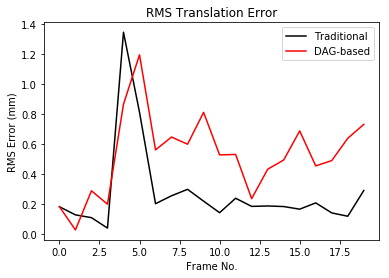

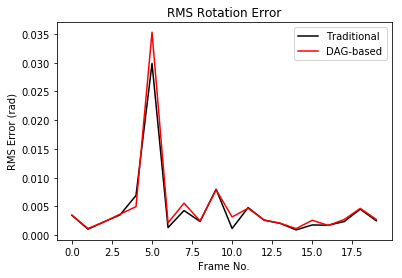

In [15]:
x = [i for i in range(len(tradTransErr))]
transRMSErrorFn=baseDir+'figures/simulation-RMSError-translation.png'
rotRMSErrorFn=baseDir+'figures/simulation-RMSError-rotation.png'
plotOverallError(x, tradTransErr, dagTransErr, "RMS Translation Error", 'Frame No.', 'RMS Error (mm)', outFn=transRMSErrorFn)
plotOverallError(x, tradRotErr, dagRotErr, "RMS Rotation Error", 'Frame No.', 'RMS Error (rad)', outFn=rotRMSErrorFn)

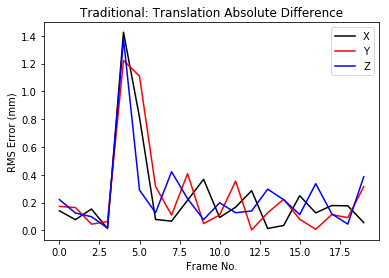

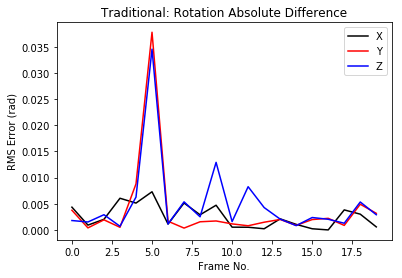

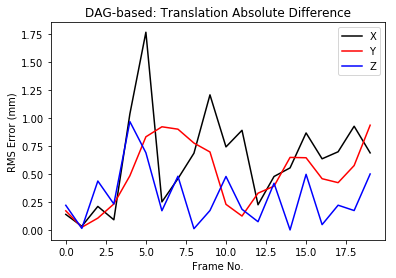

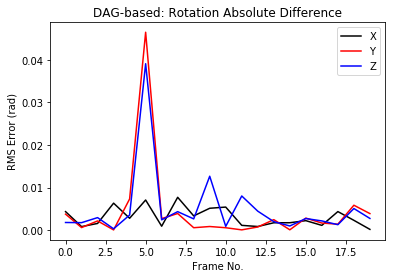

In [16]:
x = [i for i in range(len(tradTransErr))]
tradTransFn = baseDir+'figures/traditional-translationError.png'
tradRotFn = baseDir+'figures/traditional-rotationError.png'
dagTransFn = baseDir+'figures/dag-translationError.png'
dagRotFn = baseDir+'figures/dag-rotationError.png'
plotDimensionErrors(x, tradTransXErr, tradTransYErr, tradTransZErr, "Traditional: Translation Absolute Difference", 'Frame No.', 'RMS Error (mm)', outFn=tradTransFn)
plotDimensionErrors(x, tradRotXErr, tradRotYErr, tradRotZErr, "Traditional: Rotation Absolute Difference", 'Frame No.', 'RMS Error (rad)', outFn=tradRotFn)
plotDimensionErrors(x, dagTransXErr, dagTransYErr, dagTransZErr, "DAG-based: Translation Absolute Difference", 'Frame No.', 'RMS Error (mm)', outFn=dagTransFn)
plotDimensionErrors(x, dagRotXErr, dagRotYErr, dagRotZErr, "DAG-based: Rotation Absolute Difference", 'Frame No.', 'RMS Error (rad)', outFn=dagRotFn)

## Plot the correlation ratios between the corresponding frames in each sequence

In [38]:
fnOrigTrad = baseDir+"data/Simulated/metrics/cc-simulated-traditional.txt"
fnOrigDAG = baseDir+"data/Simulated/metrics/cc-simulated-dag.txt"
fnTradDAG = baseDir+"data/Simulated/metrics/cc-traditional-dag.txt"

ccOrigTrad = loadCRSignal(fnOrigTrad)
ccOrigDAG = loadCRSignal(fnOrigDAG)
ccTradDAG = loadCRSignal(fnTradDAG)

In [39]:
print(ccOrigDAG)
print(ccOrigTrad)
print(ccTradDAG)
diff = [a-b for a, b in zip(ccOrigTrad, ccOrigDAG)]

[0.0385581, 0.00552636, 0.00544214, 0.00556093, 0.00547326, 0.0056541, 0.00650084, 0.00640827, 0.00546128, 0.00533986, 0.00550687, 0.0054242, 0.00544667, 0.00546473, 0.00547224, 0.00547224, 0.00552434, 0.00557214, 0.00554979, 0.00545073, 0.00541902]
[0.040943, 0.00551486, 0.00558531, 0.00559115, 0.012564, 0.0118958, 0.011719, 0.00691503, 0.00610411, 0.00633579, 0.00589901, 0.00574321, 0.0063659, 0.00556242, 0.00561684, 0.00572348, 0.00556612, 0.0058434, 0.00605077, 0.00556576, 0.0327028]
[0.00905925, 0.00559998, 0.00557399, 0.00573218, 0.0119041, 0.0129853, 0.0117151, 0.00639939, 0.00666821, 0.0060823, 0.00616413, 0.00576019, 0.00596607, 0.00564378, 0.00567406, 0.00557911, 0.00572371, 0.00568587, 0.00621724, 0.00582057, 0.033199]


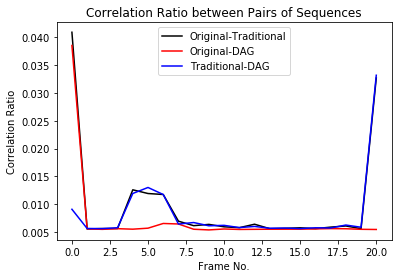

In [40]:
frames = [i for i in range(len(ccOrigDAG))]
plotCRSignal(frames, ccOrigTrad, ccOrigDAG, ccTradDAG, "Correlation Ratio between Pairs of Sequences", "Frame No.", "Correlation Ratio")

# Testing

In [20]:
import SimpleITK as sitk
import os

In [37]:
dagImgs = sorted(os.listdir(baseDir+'data/Simulated/hmm/'))
tradImgs = sorted(os.listdir(baseDir+'data/Simulated/firstTimepointMatching/'))
reader = sitk.ImageFileReader()
#tradImgs = sorted(os.listdir(baseDir+'data/Simulated/timepoints/'))


for dagImgFn, tradImgFn in zip(dagImgs, tradImgs):
    print(dagImgFn)
    reader.SetFileName(os.path.join(baseDir+'data/Simulated/hmm/', dagImgFn))
    dagImg = reader.Execute()
    dagArr = sitk.GetArrayFromImage(dagImg)

    reader.SetFileName(os.path.join(baseDir+'data/Simulated/firstTimepointMatching/', tradImgFn))
    tradImg = reader.Execute()
    tradArr = sitk.GetArrayFromImage(tradImg)
    
    if np.array_equal(dagArr, tradArr):
        print("!!!Frames are the same")
    else:
        print("Frames are NOT the same")
        
reader.SetFileName(os.path.join(baseDir+"data/Simulated/timepoints/020.nii.gz"))
orig0 = reader.Execute()
orig0Arr = sitk.GetArrayFromImage(orig0)

reader.SetFileName(os.path.join(baseDir+"data/Simulated/firstTimepointMatching/020.nii.gz"))
trad0 = reader.Execute()
trad0Arr = sitk.GetArrayFromImage(trad0)

reader.SetFileName(os.path.join(baseDir+"data/Simulated/hmm/020.nii.gz"))
dag0 = reader.Execute()
dag0Arr = sitk.GetArrayFromImage(dag0)

if np.array_equal(dag0Arr, trad0Arr) and np.array_equal(dag0Arr, orig0Arr) and np.array_equal(trad0Arr, orig0Arr):
    print("First frames are the same")
else:
    print("!!! First frames are not the same")

000.nii.gz
Frames are NOT the same
001.nii.gz
Frames are NOT the same
002.nii.gz
Frames are NOT the same
003.nii.gz
Frames are NOT the same
004.nii.gz
Frames are NOT the same
005.nii.gz
Frames are NOT the same
006.nii.gz
Frames are NOT the same
007.nii.gz
Frames are NOT the same
008.nii.gz
Frames are NOT the same
009.nii.gz
Frames are NOT the same
010.nii.gz
Frames are NOT the same
011.nii.gz
Frames are NOT the same
012.nii.gz
Frames are NOT the same
013.nii.gz
Frames are NOT the same
014.nii.gz
Frames are NOT the same
015.nii.gz
Frames are NOT the same
016.nii.gz
Frames are NOT the same
017.nii.gz
Frames are NOT the same
018.nii.gz
Frames are NOT the same
019.nii.gz
Frames are NOT the same
020.nii.gz
!!!Frames are the same
First frames are the same


# Working only with DAG and simulated sequences

## Compare the DAG and simulated sequences: should be different except for first frame.

In [52]:
# dagImgs = sorted(os.listdir(baseDir+'data/Simulated/hmmSplitFromNifti/'))
# origImgs = sorted(os.listdir(baseDir+'data/Simulated/firstTimepointMatching//'))
dagImgs = sorted(os.listdir(baseDir+'data/LinearControls/0533_TC_068_01a/timepoints/'))
origImgs = sorted(os.listdir(baseDir+'data/LinearControls/0533_TC_068_01a/firstTimepointMatching/'))
reader = sitk.ImageFileReader()


for dagImgFn, tradImgFn in zip(dagImgs, tradImgs):
    print(dagImgFn)
    reader.SetFileName(os.path.join(baseDir+'data/LinearControls/0533_TC_068_01a/timepoints/', dagImgFn))
    dagImg = reader.Execute()
    dagArr = sitk.GetArrayFromImage(dagImg)

    reader.SetFileName(os.path.join(baseDir+'data/LinearControls/0533_TC_068_01a/firstTimepointMatching/', tradImgFn))
    tradImg = reader.Execute()
    tradArr = sitk.GetArrayFromImage(tradImg)
    
    if np.array_equal(dagArr, tradArr):
        print("!!!Frames are the same")
    else:
        print("Frames are NOT the same")

000.nii.gz
!!!Frames are the same
001.nii.gz
!!!Frames are the same
002.nii.gz
!!!Frames are the same
003.nii.gz
!!!Frames are the same
004.nii.gz
!!!Frames are the same
005.nii.gz
!!!Frames are the same
006.nii.gz
!!!Frames are the same
007.nii.gz
!!!Frames are the same
008.nii.gz
Frames are NOT the same
009.nii.gz
Frames are NOT the same
010.nii.gz
Frames are NOT the same
011.nii.gz
Frames are NOT the same
012.nii.gz
Frames are NOT the same
013.nii.gz
Frames are NOT the same
014.nii.gz
Frames are NOT the same
015.nii.gz
Frames are NOT the same
016.nii.gz
Frames are NOT the same
017.nii.gz
Frames are NOT the same
018.nii.gz
!!!Frames are the same
019.nii.gz
!!!Frames are the same
020.nii.gz
!!!Frames are the same


## Generate the correlation ratios between the corresponding frames in each sequence (done through bash)

## Read in and plot the correlation ratios

## Run python calculateRigidTransforms.py to generate the pairwise rigid transformations for each sequence (done separately)

## Compare the transforms